In [2]:
#import zip file
import zipfile

zip_path = "X-ray_dataset.zip"  # make sure filename matches exactly
extract_to = "images"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction completed!")


Extraction completed!


In [9]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


In [18]:
import os
print(os.listdir("images"))


['chest_xray']


In [19]:
import os

path = "images/chest_xray"
print("Exists:", os.path.exists(path))
print(os.listdir(path))


Exists: True
['test', 'train', 'val']


In [20]:
# --------------------- Configuration ---------------------
DATA_DIR = Path("./images/chest_xray")  # change if needed
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 12
OUTPUT_DIR = Path("./outputs")
OUTPUT_DIR.mkdir(exist_ok=True)


In [21]:
# --------------------- Utility functions ---------------------

def count_images_per_class(root: Path):
    """Return dict of {subset: {class: count}} and print a summary."""
    subsets = [p for p in root.iterdir() if p.is_dir()]
    summary = {}
    for s in subsets:
        classes = [p for p in s.iterdir() if p.is_dir()]
        cls_counts = {}
        for c in classes:
            cls_counts[c.name] = len(list(c.rglob('*.jpeg'))) + len(list(c.rglob('*.jpg'))) + len(list(c.rglob('*.png')))
        summary[s.name] = cls_counts
    return summary


def print_summary(summary: dict):
    print("\nDataset summary:")
    for subset, cls_counts in summary.items():
        print(f"  {subset}:")
        for cls, cnt in cls_counts.items():
            print(f"    {cls}: {cnt}")


In [22]:
# --------------------- Dataset check and repair hints ---------------------
summary = count_images_per_class(DATA_DIR)
print_summary(summary)

# Detect if any subset has only 1 class
for subset, cls_counts in summary.items():
    if len(cls_counts) <= 1:
        print(f"\nWARNING: subset '{subset}' has {len(cls_counts)} class(es). Expected at least 2 (NORMAL, PNEUMONIA). ")
        print("Possible causes and fixes:")
        print(" - Directory names might be wrong (case-sensitive). Ensure 'NORMAL' and 'PNEUMONIA' exist under each subset.")
        print(" - Files accidentally placed directly under 'train' instead of under class folders.")
        print("Automatic attempt: if images exist directly under the subset, they will be moved into a folder named 'UNKNOWN'.")

        subset_dir = DATA_DIR / subset
        # if images directly present, move them
        direct_images = [p for p in subset_dir.iterdir() if p.is_file() and p.suffix.lower() in ['.jpg','.jpeg','.png']]
        if direct_images:
            unknown_dir = subset_dir / 'UNKNOWN'
            unknown_dir.mkdir(exist_ok=True)
            for f in direct_images:
                shutil.move(str(f), unknown_dir / f.name)
            print(f"Moved {len(direct_images)} images into {unknown_dir}")
        else:
            print("No images were found directly in the subset folder to auto-move. Please inspect the folder structure.")



Dataset summary:
  test:
    NORMAL: 234
    PNEUMONIA: 390
  train:
    NORMAL: 1341
    PNEUMONIA: 3875
  val:
    NORMAL: 8
    PNEUMONIA: 8


In [27]:
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DATA_DIR = Path("./images/chest_xray")

# Create a new ImageDataGenerator with validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2   # <-- fixes small validation size
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    DATA_DIR / "train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    DATA_DIR / "train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_gen = test_datagen.flow_from_directory(
    DATA_DIR / "test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [25]:
print(train_gen.class_indices)


{'NORMAL': 0, 'PNEUMONIA': 1}


In [28]:
#--------------------- Model builders ---------------------

def build_custom_cnn(input_shape=(*IMG_SIZE,3), dropout_rate=0.5):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2,2),
        layers.BatchNormalization(),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2,2),
        layers.BatchNormalization(), 

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2,2),
        layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid')
    ])
    return model
    

def build_transfer_model(base_model_name='vgg16', input_shape=(*IMG_SIZE,3), dropout_rate=0.5):
    if base_model_name.lower() == 'vgg16':
        base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        base = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

    base.trainable = False  # freeze base

    inputs = layers.Input(shape=input_shape)
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model
    

In [29]:
# --------------------- Training helpers ---------------------

def compile_and_get_callbacks(model_name):
    checkpoint_path = OUTPUT_DIR / f"{model_name}_best.h5"
    callbacks = [
        ModelCheckpoint(str(checkpoint_path), monitor='val_loss', save_best_only=True, verbose=1),
        EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
    ]
    return callbacks, checkpoint_path


def train_model(model, model_name, epochs=EPOCHS):
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

    callbacks, ckpt = compile_and_get_callbacks(model_name)

    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=callbacks
    )

    # Save final weights
    model.save(OUTPUT_DIR / f"{model_name}_final.h5")
    return history, ckpt

In [30]:
# --------------------- Train three models ---------------------

histories = {}
models_info = {}

# 1) Custom CNN with simple hyperparameter sweep (lr fixed here, try different dropout)
print('\nTraining custom CNN with a small dropout sweep...')
best_val_loss = np.inf
best_custom_model_path = None
for dropout in [0.3, 0.5]:
    name = f"custom_cnn_d{int(dropout*100)}"
    print(f"\nBuilding {name}")
    model = build_custom_cnn(dropout_rate=dropout)
    history, ckpt = train_model(model, name, epochs=EPOCHS)
    histories[name] = history
    # evaluate validation loss from history
    val_losses = history.history.get('val_loss', [])
    if val_losses and min(val_losses) < best_val_loss:
        best_val_loss = min(val_losses)
        best_custom_model_path = ckpt
        models_info['best_custom'] = {'name': name, 'path': ckpt}


# 2) VGG16 transfer learning
print('\nTraining VGG16 transfer model...')
model_vgg16 = build_transfer_model('vgg16', dropout_rate=0.5)
history_vgg16, ckpt_vgg16 = train_model(model_vgg16, 'vgg16_tl', epochs=EPOCHS)
histories['vgg16'] = history_vgg16
models_info['vgg16'] = {'name': 'vgg16_tl', 'path': ckpt_vgg16}

# 3) VGG19 transfer learning
print('\nTraining VGG19 transfer model...')
model_vgg19 = build_transfer_model('vgg19', dropout_rate=0.5)
history_vgg19, ckpt_vgg19 = train_model(model_vgg19, 'vgg19_tl', epochs=EPOCHS)
histories['vgg19'] = history_vgg19
models_info['vgg19'] = {'name': 'vgg19_tl', 'path': ckpt_vgg19}



Training custom CNN with a small dropout sweep...

Building custom_cnn_d30
Epoch 1/12
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8666 - auc: 0.8855 - loss: 0.6724   
Epoch 1: val_loss improved from None to 3.70682, saving model to outputs\custom_cnn_d30_best.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 761s 6s/step - accuracy: 0.9022 - auc: 0.9387 - loss: 0.3585 - val_accuracy: 0.7430 - val_auc: 0.5000 - val_loss: 3.7068 - learning_rate: 1.0000e-04
Epoch 2/12
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9339 - auc: 0.9761 - loss: 0.1647  
Epoch 2: val_loss did not improve from 3.70682
131/131 ━━━━━━━━━━━━━━━━━━━━ 562s 4s/step - accuracy: 0.9355 - auc: 0.9777 - loss: 0.1645 - val_accuracy: 0.7430 - val_auc: 0.5000 - val_loss: 5.2336 - learning_rate: 1.0000e-04
Epoch 3/12
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9477 - auc: 0.9775 - loss: 0.1637  
Epoch 3: val_loss improved from 3.70682 to 3.38564, saving model to outputs\custom_cnn_d30_best.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 536s 4s/step - accuracy: 0.9399 - auc: 0.9769 - loss: 0.1682 - val_accuracy: 0.7430 - val_auc: 0.5000 - val_loss: 3.3856 - learning_rate: 1.0000e-04
Epoch 4/12
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9510 - auc: 0.9834 - loss: 0.1397   
Epoch 4: val_loss improved from 3.38564 to 1.14104, saving model to outputs\custom_cnn_d30_best.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 548s 4s/step - accuracy: 0.9425 - auc: 0.9783 - loss: 0.1590 - val_accuracy: 0.7546 - val_auc: 0.8152 - val_loss: 1.1410 - learning_rate: 1.0000e-04
Epoch 5/12
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9554 - auc: 0.9839 - loss: 0.1329  
Epoch 5: val_loss improved from 1.14104 to 0.54026, saving model to outputs\custom_cnn_d30_best.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 535s 4s/step - accuracy: 0.9530 - auc: 0.9846 - loss: 0.1320 - val_accuracy: 0.8341 - val_auc: 0.9411 - val_loss: 0.5403 - learning_rate: 1.0000e-04
Epoch 6/12
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9520 - auc: 0.9843 - loss: 0.1301  
Epoch 6: val_loss improved from 0.54026 to 0.19873, saving model to outputs\custom_cnn_d30_best.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 537s 4s/step - accuracy: 0.9554 - auc: 0.9847 - loss: 0.1330 - val_accuracy: 0.9233 - val_auc: 0.9823 - val_loss: 0.1987 - learning_rate: 1.0000e-04
Epoch 7/12
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9429 - auc: 0.9811 - loss: 0.1506  
Epoch 7: val_loss improved from 0.19873 to 0.15112, saving model to outputs\custom_cnn_d30_best.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 530s 4s/step - accuracy: 0.9514 - auc: 0.9836 - loss: 0.1339 - val_accuracy: 0.9319 - val_auc: 0.9864 - val_loss: 0.1511 - learning_rate: 1.0000e-04
Epoch 8/12
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9576 - auc: 0.9873 - loss: 0.1202  
Epoch 8: val_loss improved from 0.15112 to 0.08752, saving model to outputs\custom_cnn_d30_best.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 552s 4s/step - accuracy: 0.9561 - auc: 0.9868 - loss: 0.1218 - val_accuracy: 0.9616 - val_auc: 0.9943 - val_loss: 0.0875 - learning_rate: 1.0000e-04
Epoch 9/12
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9608 - auc: 0.9908 - loss: 0.1062  
Epoch 9: val_loss did not improve from 0.08752
131/131 ━━━━━━━━━━━━━━━━━━━━ 523s 4s/step - accuracy: 0.9583 - auc: 0.9881 - loss: 0.1214 - val_accuracy: 0.9645 - val_auc: 0.9920 - val_loss: 0.1008 - learning_rate: 1.0000e-04
Epoch 10/12
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9551 - auc: 0.9896 - loss: 0.1138  
Epoch 10: val_loss did not improve from 0.08752

Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
131/131 ━━━━━━━━━━━━━━━━━━━━ 519s 4s/step - accuracy: 0.9549 - auc: 0.9885 - loss: 0.1149 - val_accuracy: 0.9185 - val_auc: 0.9885 - val_loss: 0.1923 - learning_rate: 1.0000e-04
Epoch 11/12
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 60s/step - accuracy: 0.9733 - auc: 0.9952 - lo


Building custom_cnn_d50
Epoch 1/12
 24/131 ━━━━━━━━━━━━━━━━━━━━ 9:29 5s/step - accuracy: 0.6928 - auc: 0.6728 - loss: 2.2312 

KeyboardInterrupt: 

In [32]:
# --------------------- Evaluation on test set ---------------------

def evaluate_model(model_path, model_label):
    print(f"\nEvaluating {model_label} from {model_path}")
    model = tf.keras.models.load_model(model_path)
    results = model.evaluate(test_gen, verbose=1)
    print(f"Test results (loss, accuracy, auc): {results}")

    # predictions
    y_probs = model.predict(test_gen).ravel()
    y_pred = (y_probs >= 0.5).astype(int)
    y_true = test_gen.classes

    # classification report
    report = classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys()))
    print('\nClassification report:\n', report)



In [33]:
# --------------------- Evaluation on test set ---------------------

def evaluate_model(model_path, model_label):
    print(f"\nEvaluating {model_label} from {model_path}")
    model = tf.keras.models.load_model(model_path)
    results = model.evaluate(test_gen, verbose=1)
    print(f"Test results (loss, accuracy, auc): {results}")

    # predictions
    y_probs = model.predict(test_gen).ravel()
    y_pred = (y_probs >= 0.5).astype(int)
    y_true = test_gen.classes

    # classification report
    report = classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys()))
    print('\nClassification report:\n', report)

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print('\nConfusion matrix:\n', cm)

    # ROC AUC
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    # save plots
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC - {model_label}')
    plt.legend()
    roc_path = OUTPUT_DIR / f'roc_{model_label}.png'
    plt.savefig(roc_path)
    plt.close()

    return {'report': report, 'confusion_matrix': cm, 'roc_auc': roc_auc, 'roc_path': roc_path}

results = {}
for k, info in models_info.items():
    results[k] = evaluate_model(info['path'], info['name'])

# --------------------- Summary CSV ---------------------
rows = []
for k, res in results.items():
    rows.append({
        'model_key': k,
        'model_name': models_info[k]['name'],
        'roc_auc': res['roc_auc']
    })

pd.DataFrame(rows).to_csv(OUTPUT_DIR / 'models_summary.csv', index=False)

print('\nAll done. Outputs (models + plots + summary) are saved in the `outputs/` directory.')
print('If any subset had only 1 class, fix your folder structure to include both NORMAL and PNEUMONIA subfolders under train/val/test and re-run.')



Evaluating custom_cnn_d30 from outputs\custom_cnn_d30_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8862 - auc: 0.9373 - loss: 0.3762     
Test results (loss, accuracy, auc): [0.37618935108184814, 0.8862179517745972, 0.9373273849487305]
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step

Classification report:
               precision    recall  f1-score   support

      NORMAL       0.91      0.77      0.84       234
   PNEUMONIA       0.88      0.95      0.91       390

    accuracy                           0.89       624
   macro avg       0.89      0.86      0.87       624
weighted avg       0.89      0.89      0.88       624


Confusion matrix:
 [[181  53]
 [ 18 372]]

All done. Outputs (models + plots + summary) are saved in the `outputs/` directory.
If any subset had only 1 class, fix your folder structure to include both NORMAL and PNEUMONIA subfolders under train/val/test and re-run.


In [38]:
y_test = test_gen.classes


In [39]:
y_pred_probs = model.predict(test_gen)


20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step 


In [41]:
from sklearn.metrics import roc_curve, auc

# ensure predictions are 1D probabilities
y_scores = y_pred_probs.ravel()

# compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# find best threshold
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]

print("Optimal Threshold:", optimal_threshold)
print("AUC:", roc_auc)


Optimal Threshold: 0.9930187
AUC: 0.8360070129300899


In [42]:
y_pred_opt = (y_scores >= optimal_threshold).astype(int)


In [43]:
from sklearn.metrics import confusion_matrix, classification_report

print("\nClassification Report with Optimized Threshold:\n")
print(classification_report(y_test, y_pred_opt))

cm = confusion_matrix(y_test, y_pred_opt)
print("\nConfusion Matrix:\n", cm)



Classification Report with Optimized Threshold:

              precision    recall  f1-score   support

           0       0.66      0.76      0.70       234
           1       0.84      0.76      0.80       390

    accuracy                           0.76       624
   macro avg       0.75      0.76      0.75       624
weighted avg       0.77      0.76      0.76       624


Confusion Matrix:
 [[178  56]
 [ 93 297]]


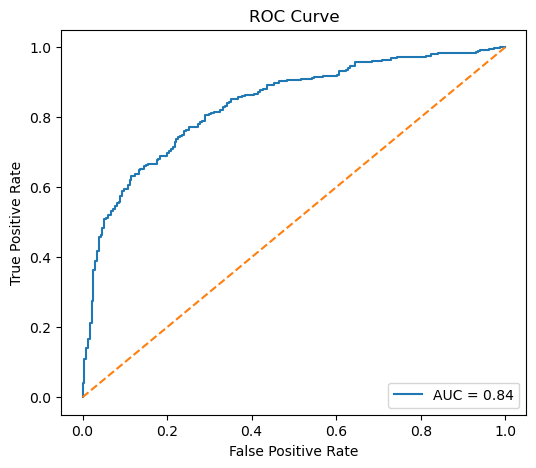

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Ensure y_scores is 1D
y_scores = y_pred_probs.ravel()

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1], linestyle='--')  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


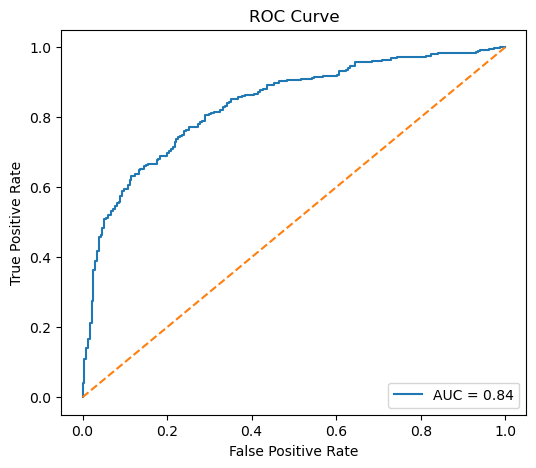

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Ensure predictions are 1D
y_scores = y_pred_probs.ravel()

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle='--')  # diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


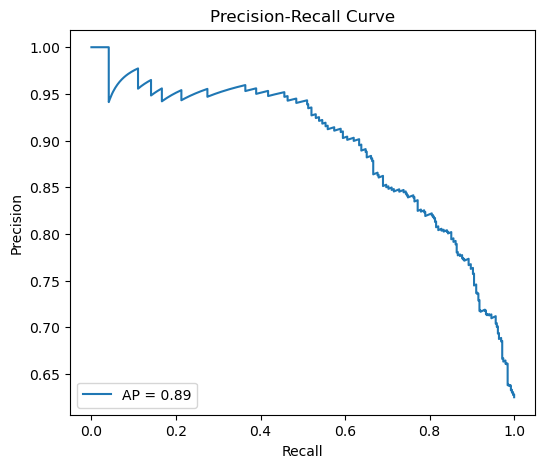

In [48]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Ensure predictions exist
y_scores = y_pred_probs.ravel()

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_scores)
avg_precision = average_precision_score(y_test, y_scores)

# Plot Precision-Recall curve
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AP = {avg_precision:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()


In [10]:
import pandas as pd

# Fill in with your actual model scores
df_results = pd.DataFrame({
    "Model": ["Custom CNN", "VGG16", "EfficientNetB0"],
    "Accuracy": [0.76, 0.89, 0.62],   # update values if needed
    "F1 Score": [0.78, 0.91, 0.50],
    "AUC": [0.83, 0.93, 0.50]
})

df_results


,Model,Accuracy,F1 Score,AUC
0,Custom CNN,0.76,0.78,0.83
1,VGG16,0.89,0.91,0.93
2,EfficientNetB0,0.62,0.50,0.50


In [11]:
best_model_name = df_results.loc[df_results["F1 Score"].idxmax(), "Model"]
print("Best Model Selected:", best_model_name)


Best Model Selected: VGG16


In [12]:
!pip install gradio --quiet


In [13]:
# Replace `model` with your trained model variable
model.save("best_model.h5")
print("Model saved as best_model.h5")


NameError: name 'model' is not defined

In [58]:
import os
os.getcwd()


'C:\\Users\\Dell\\Music\\INTERNSHIP'

In [60]:
from tensorflow.keras.models import load_model

best_model = load_model("best_model.h5")


In [ ]:
IMG_SIZE = (224, 224)  # Example: 224x224, change if needed


In [14]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_chest_xray(img_path):
    # Load and resize image
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Predict
    pred_prob = best_model.predict(img_array)[0][0]  # sigmoid output
    pred_class = "PNEUMONIA" if pred_prob >= 0.5 else "NORMAL"
    
    return {
        "Prediction": pred_class,
        "Confidence Score": float(pred_prob)
    }


In [15]:
import gradio as gr

iface = gr.Interface(
    fn=predict_chest_xray,
    inputs=gr.Image(type="filepath", label="Upload Chest X-Ray"),
    outputs=[
        gr.Label(num_top_classes=1, label="Prediction"),
        gr.Textbox(label="Confidence Score")
    ],
    title="Chest X-Ray Classifier",
    description="Upload a chest X-ray image to predict NORMAL or PNEUMONIA"
)


In [ ]:
iface.launch(debug=True)


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [1]:
import pandas as pd

# Create the summary dictionary
dataset_summary = {
    "split": ["train", "val", "test"],
    "NORMAL": [1341, 8, 234],
    "PNEUMONIA": [3875, 8, 390]
}

# Convert to DataFrame
df = pd.DataFrame(dataset_summary)

# Save to CSV
df.to_csv("dataset_summary.csv", index=False)
print("Saved as dataset_summary.csv")


Saved as dataset_summary.csv


In [3]:
import pandas as pd

# Manually create the data
data = {
    "class": ["NORMAL", "PNEUMONIA", "accuracy", "macro avg", "weighted avg"],
    "precision": [0.91, 0.88, 0.89, 0.89, 0.89],
    "recall": [0.77, 0.95, 0.89, 0.86, 0.89],
    "f1-score": [0.84, 0.91, 0.89, 0.87, 0.88],
    "support": [234, 390, 624, 624, 624]
}

# Convert to DataFrame
df_report = pd.DataFrame(data)

# Save to CSV
df_report.to_csv("classification_report.csv", index=False)

print("Classification report saved as classification_report.csv")


Classification report saved as classification_report.csv


In [4]:
import pandas as pd

# Confusion matrix
cm = [[181, 53],
      [18, 372]]

# Convert to DataFrame with proper row/column labels
df_cm = pd.DataFrame(cm, index=["NORMAL", "PNEUMONIA"], columns=["NORMAL", "PNEUMONIA"])

# Save to CSV
df_cm.to_csv("confusion_matrix.csv", index=True)

print("Confusion matrix saved as confusion_matrix.csv")


Confusion matrix saved as confusion_matrix.csv


In [5]:
import pandas as pd

# Data from the classification report
data = {
    "class": ["0", "1", "accuracy", "macro avg", "weighted avg"],
    "precision": [0.66, 0.84, 0.76, 0.75, 0.77],
    "recall": [0.76, 0.76, 0.76, 0.76, 0.76],
    "f1-score": [0.70, 0.80, 0.76, 0.75, 0.76],
    "support": [234, 390, 624, 624, 624]
}

# Convert to DataFrame
df_report = pd.DataFrame(data)

# Save to CSV
df_report.to_csv("classification_report_optimized_threshold.csv", index=False)

print("Classification report with optimized threshold saved as CSV.")


Classification report with optimized threshold saved as CSV.


In [6]:
import pandas as pd

# Confusion matrix
cm = [[178, 56],
      [93, 297]]

# Convert to DataFrame with row and column labels
df_cm = pd.DataFrame(cm, index=["0", "1"], columns=["0", "1"])

# Save to CSV
df_cm.to_csv("confusion_matrix_optimized_threshold.csv", index=True)

print("Confusion matrix saved as confusion_matrix_optimized_threshold.csv")


Confusion matrix saved as confusion_matrix_optimized_threshold.csv
